В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [16]:
import os
os.listdir()

['.config', 'bank-customer-churn-prediction-dlu-course-c-3', 'sample_data']

Area under ROC score on Train dataset: 76.95%


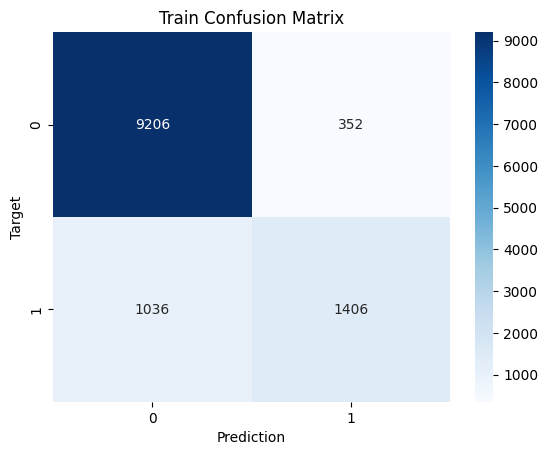

Area under ROC score on Validation dataset: 75.79%


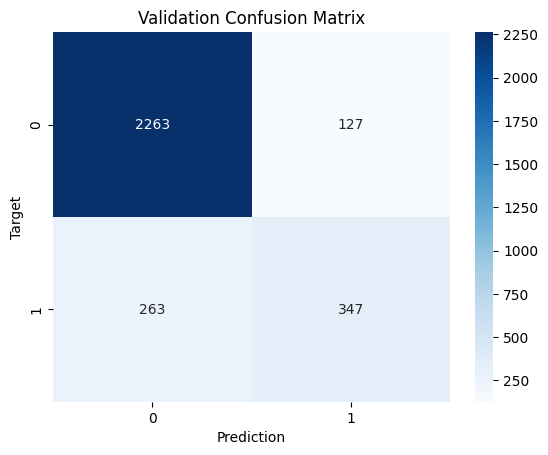

['logistic_pipeline.joblib']

In [18]:

# ------------------ Імпорти ------------------
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix

# ------------------ Читання даних ------------------
test_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-3/test.csv', index_col=0)
raw_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-3/train.csv', index_col=0)

# ------------------ Розбиття на train/val ------------------
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'

train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# ------------------ Категоріальні/Числові ------------------
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# ------------------ Трансформери ------------------
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ------------------ Препроцесор ------------------
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# ------------------ Модельний пайплайн ------------------
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# ------------------ Навчання ------------------
model_pipeline.fit(train_inputs, train_targets)

# ------------------ Функція оцінки ------------------
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    roc_auc = roc_auc_score(targets, preds)
    print(f"Area under ROC score on {name} dataset: {roc_auc * 100:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds)
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    return preds

# ------------------ Оцінка ------------------
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name='Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, name='Validation')

# ------------------ Збереження ------------------
joblib.dump(model_pipeline, 'logistic_pipeline.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [19]:
from sklearn.preprocessing import PolynomialFeatures

numeric_transformer_poly = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', MinMaxScaler())
])

In [20]:
# Новий препроцесор
preprocessor_poly = ColumnTransformer(transformers=[
    ('num', numeric_transformer_poly, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Новий пайплайн
model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(max_iter=1000))
])


Area under ROC score on Train with poly dataset: 78.95%


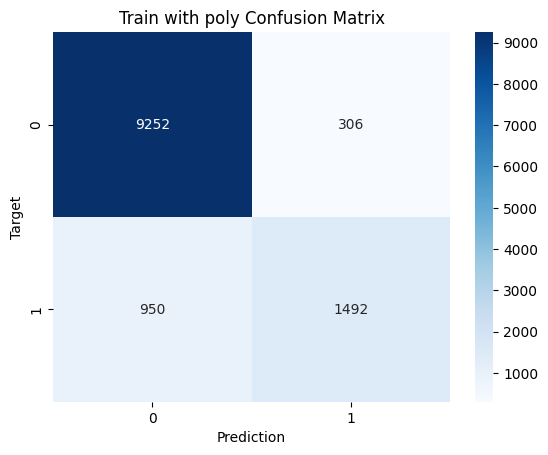

Area under ROC score on Validation with poly dataset: 77.76%


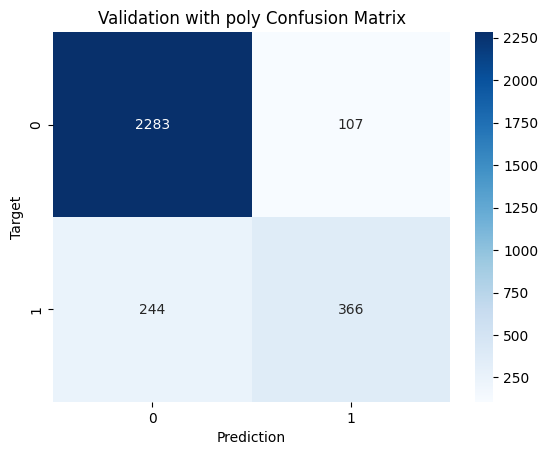

In [21]:
# Тренування
model_pipeline_poly.fit(train_inputs, train_targets)

# Оцінка
train_preds_poly = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, name='Train with poly')
val_preds_poly = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, name='Validation with poly')


**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

In [22]:
from sklearn.preprocessing import PolynomialFeatures

numeric_transformer_poly4 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', MinMaxScaler())
])


In [23]:
# Новий препроцесор
preprocessor_poly4 = ColumnTransformer(transformers=[
    ('num', numeric_transformer_poly4, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Новий пайплайн
model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', LogisticRegression(max_iter=1000))
])


Area under ROC score on Train poly deg=4 dataset: 82.58%


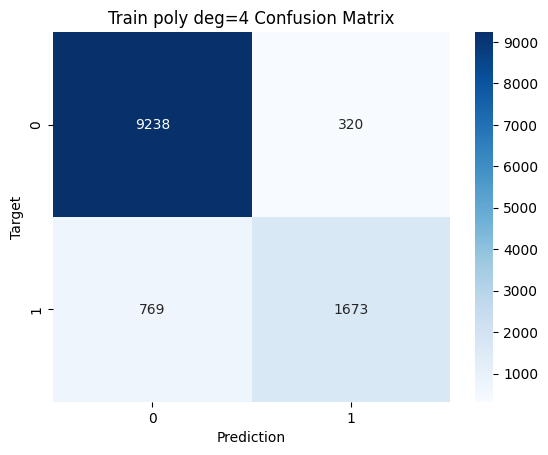

Area under ROC score on Validation poly deg=4 dataset: 80.86%


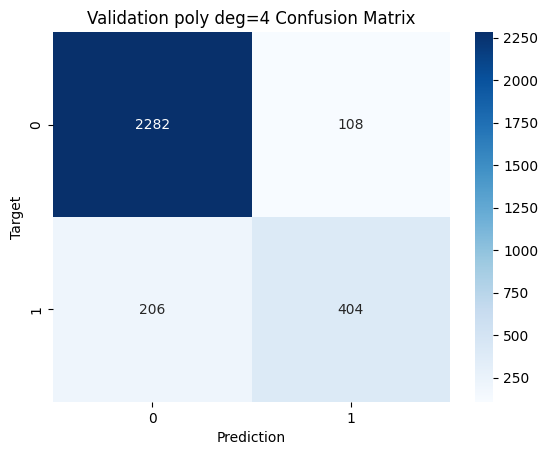

In [24]:
# Тренування
model_pipeline_poly4.fit(train_inputs, train_targets)

# Оцінка
train_preds_poly4 = predict_and_plot(model_pipeline_poly4, train_inputs, train_targets, name='Train poly deg=4')
val_preds_poly4 = predict_and_plot(model_pipeline_poly4, val_inputs, val_targets, name='Validation poly deg=4')


In [25]:
# Зчитуємо test.csv
test_inputs = test_df[input_cols]

# Передбачаємо ймовірність для класу 1
test_preds = model_pipeline_poly4.predict(test_inputs)

# Формуємо submission DataFrame
submission = pd.DataFrame({
    'id': test_df.index,
    'Exited': test_preds
})

# Зберігаємо у CSV
submission.to_csv('submission.csv', index=False)

# Перевіримо кілька перших рядків
submission.head()


,id,Exited
0,15000,0.0
1,15001,0.0
2,15002,0.0
3,15003,0.0
4,15004,0.0


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [26]:
from google.colab import files
uploaded = files.upload()

Saving regression_data.csv to regression_data.csv


In [28]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Зчитування даних
df = pd.read_csv('regression_data.csv')
X = df.drop(columns='target')
y = df['target']

# Розділення на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Пайплайн: поліноміальні ознаки + масштабування + регресія
model_pipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', MinMaxScaler()),
    ('regressor', LinearRegression())
])

# Навчання
model_pipeline.fit(X_train, y_train)

# Оцінка
def evaluate(X, y, dataset_name):
    preds = model_pipeline.predict(X)
    rmse = mean_squared_error(y, preds) ** 0.5
    r2 = r2_score(y, preds)
    print(f'{dataset_name} RMSE: {rmse:.3f}')
    print(f'{dataset_name} R²: {r2:.3f}')
    return rmse, r2

train_metrics = evaluate(X_train, y_train, 'Train')
test_metrics = evaluate(X_test, y_test, 'Test')


Train RMSE: 0.000
Train R²: 1.000
Test RMSE: 12.363
Test R²: 0.934


**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [29]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

# Поліноміальні ознаки до степеня 20
poly = PolynomialFeatures(degree=20, include_bias=False)
scaler = MinMaxScaler()

X_train_poly = scaler.fit_transform(poly.fit_transform(X_train))
X_test_poly = scaler.transform(poly.transform(X_test))

# Функція для оцінки моделей
def evaluate_model(model, name):
    model.fit(X_train_poly, y_train)
    train_preds = model.predict(X_train_poly)
    test_preds = model.predict(X_test_poly)

    train_rmse = mean_squared_error(y_train, train_preds) ** 0.5
    test_rmse = mean_squared_error(y_test, test_preds) ** 0.5
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)

    print(f"\n{name}")
    print(f"Train RMSE: {train_rmse:.3f}, R²: {train_r2:.3f}")
    print(f"Test  RMSE: {test_rmse:.3f}, R²: {test_r2:.3f}")
    return test_r2

# Запускаємо всі 3 моделі
evaluate_model(Ridge(alpha=1.0), "Ridge")
evaluate_model(Lasso(alpha=0.001, max_iter=10000), "Lasso")
evaluate_model(ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000), "ElasticNet")



Ridge
Train RMSE: 8.598, R²: 0.962
Test  RMSE: 76.563, R²: -1.513

Lasso
Train RMSE: 0.541, R²: 1.000
Test  RMSE: 6.114, R²: 0.984

ElasticNet
Train RMSE: 1.193, R²: 0.999
Test  RMSE: 16.318, R²: 0.886


0.8858729961280339

Найкраща модель — Lasso

Вона має ідеальне навчання (R² = 1.0) та дуже високу якість на тесті (R² = 0.984)

Це означає, що вона не переобучилась, хоча дані були сильно розширені до 20-го степеня

Lasso ще й автоматично відкидає нерелевантні ознаки (обнуляє ваги), тобто виконує фічер селекшн

In [31]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.001, max_iter=10000)
lasso.fit(X_train_poly, y_train)


Lasso(alpha=0.001, max_iter=10000)

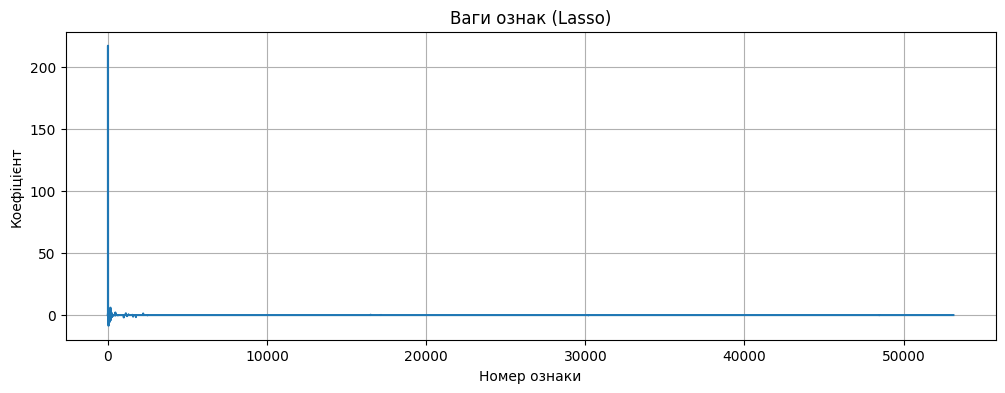

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(lasso.coef_)
plt.title("Ваги ознак (Lasso)")
plt.xlabel("Номер ознаки")
plt.ylabel("Коефіцієнт")
plt.grid(True)
plt.show()